# SupplyChain Module

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from climada.util.api_client import Client
from climada_petals.engine import SupplyChain
from climada.entity import ImpfTropCyclone, ImpactFuncSet
from climada.engine.impact_calc import ImpactCalc
import datetime as dt

client = Client()

This tutorial shows how to use the `SupplyChain` class of CLIMADA. This class allows assessing indirect impacts via Input-Output modeling. Before diving into this class, it is highly recommended that the user first understands how direct impact is calculated with CLIMADA. This requires getting familiar with the `Exposures`, `Hazard` and `Impact` classes.

This tutorial shows how to set up a global supply chain risk analysis of tropical cyclones that hit the United States.

# 1. Calculate direct economic impacts

The first step is to conduct a direct impact anlysis. To do so, we need to define an exposure, an hazard and a vulnerability. In this tutorial we will load the LitPop exposure for the USA from CLIMADA Data API.

In [3]:
exp_usa = client.get_litpop('USA')

2023-07-26 17:32:09,215 - climada.entity.exposures.base - INFO - Reading /Users/aciullo/climada/data/exposures/litpop/LitPop_150arcsec_USA/v2/LitPop_150arcsec_USA.hdf5


/Users/aciullo/opt/anaconda3/envs/climada_env/lib/python3.9/pickle.py:1717: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  setstate(state)


Then, we load observed tropical cyclones for the USA from the CLIMADA Data API and from therein select few relevant events.

In [4]:
tc_usa = client.get_hazard('tropical_cyclone', 
                           properties={'country_iso3alpha':'USA', 'event_type': 'observed'})

2023-07-26 17:32:19,958 - climada.hazard.base - INFO - Reading /Users/aciullo/climada/data/hazard/tropical_cyclone/tropical_cyclone_0synth_tracks_150arcsec_historical_USA_1980_2020/v2/tropical_cyclone_0synth_tracks_150arcsec_historical_USA_1980_2020.hdf5


In [5]:
target_year = 2017
events_in_target_year = np.array([
    tc_usa.event_name[i] for i in range(len(tc_usa.event_name)) if 
    dt.datetime.fromordinal(tc_usa.date[i]).year == target_year
    ])


In [6]:
tc_usa_target_year = tc_usa.select(event_names = events_in_target_year)

Then we define vulnerability by loading impact functions for tropical cyclone in the USA:

In [7]:
# Define impact function
impf_tc = ImpfTropCyclone.from_emanuel_usa()
impf_set = ImpactFuncSet()
impf_set.append(impf_tc)
impf_set.check()

And we finally calculate impacts.

In [8]:
# Calculate direct impacts to the USA due to TC
imp_calc = ImpactCalc(exp_usa, impf_set, tc_usa_target_year)
direct_impact_usa = imp_calc.impact()

2023-07-26 17:32:20,061 - climada.entity.exposures.base - INFO - No specific impact function column found for hazard TC. Using the anonymous 'impf_' column.
2023-07-26 17:32:20,061 - climada.entity.exposures.base - INFO - Matching 643099 exposures with 610031 centroids.
2023-07-26 17:32:20,069 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-07-26 17:32:21,109 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 19942 coordinates.
2023-07-26 17:32:21,138 - climada.engine.impact_calc - INFO - Calculating impact for 1414728 assets (>0) and 106 events.


# 2. Calculate indirect economic impacts

## 2.1 Instantiate a `SupplyChain` object by loading the Multi-Regional Input-Output Table of interest.

`SupplyChain` computes indirect economic impacts via Input-Output (IO) modeling. At the core of IO modeling lies an Input-Output Table. `SupplyChain` uses the [pymrio](https://pymrio.readthedocs.io/en/latest/) python package to download, parse and save Multi-Regional Input Output Tables (MRIOTs). In principle, any IO table can be loaded and used, as long as the structure is consistent with those internally supported by `SupplyChain`, which are:
- [EXIOBASE3](https://zenodo.org/record/3583071#.Y_4zZuzMK3I) (1995-2011; 44 countries; 163 industries)​
- [WIOD16](https://www.rug.nl/ggdc/valuechain/wiod/) (2000-2014; 43 countries; 56 industries)​
- [OECD21](https://www.oecd.org/sti/ind/inter-country-input-output-tables.htm) (1995-2018; 66 countries; 45 industries)​

These MRIOTs can be downloaded, parsed and saved automatically.

The first step is to instantiate a `SupplyChain` class. This can be done by passing a customized MRIOT or by calling the `from_mriot` class method and use one of the supported MRIOTs.

In [9]:
supchain = SupplyChain.from_mriot(mriot_type='WIOD16', mriot_year=2011)

The instatiated class now has an `mriot` attribute, which is a pymrio `IOSystem` object:

In [10]:
supchain.mriot

As such, one can access several info of the MRIOT incl. regions, sectors, total production, transaction matrix and final demand. Please see the pymrio project on how to make best use of all the provided functions. For example, one can access regions, sectors and IOT data:

In [11]:
# regions
supchain.mriot.get_regions()

Index(['AUS', 'AUT', 'BEL', 'BGR', 'BRA', 'CAN', 'CHE', 'CHN', 'CYP', 'CZE',
       'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC', 'HRV', 'HUN',
       'IDN', 'IND', 'IRL', 'ITA', 'JPN', 'KOR', 'LTU', 'LUX', 'LVA', 'MEX',
       'MLT', 'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'RUS', 'SVK', 'SVN', 'SWE',
       'TUR', 'TWN', 'USA', 'ROW'],
      dtype='object', name='region')

In [12]:
# sectors
supchain.mriot.get_sectors()

Index(['Crop and animal production, hunting and related service activities',
       'Forestry and logging', 'Fishing and aquaculture',
       'Mining and quarrying',
       'Manufacture of food products, beverages and tobacco products',
       'Manufacture of textiles, wearing apparel and leather products',
       'Manufacture of wood and of products of wood and cork, except furniture; manufacture of articles of straw and plaiting materials',
       'Manufacture of paper and paper products',
       'Printing and reproduction of recorded media',
       'Manufacture of coke and refined petroleum products ',
       'Manufacture of chemicals and chemical products ',
       'Manufacture of basic pharmaceutical products and pharmaceutical preparations',
       'Manufacture of rubber and plastic products',
       'Manufacture of other non-metallic mineral products',
       'Manufacture of basic metals',
       'Manufacture of fabricated metal products, except machinery and equipment',
       

In [13]:
# transaction matrix
supchain.mriot.Z

region                                                                                                                   AUS  \
sector                                                    Crop and animal production, hunting and related service activities   
region sector                                                                                                                  
AUS    Crop and animal production, hunting and related...                                       10954.209508                   
       Forestry and logging                                                                       113.905445                   
       Fishing and aquaculture                                                                     22.267974                   
       Mining and quarrying                                                                       232.437685                   
       Manufacture of food products, beverages and tob...                                        1662.225516                   
...                                                                                                      ...                   
ROW    Education                                                                                    1.305193                   
       Human health and social work activities                                                      0.535337                   
       Other service activities                                                                     1.856064                   
       Activities of households as employers; undiffer...                                           0.027816                   
       Activities of extraterritorial organizations an...                                           0.000000                   

region                                                                          \
sector                                                    Forestry and logging   
region sector                                                                    
AUS    Crop and animal production, hunting and related...           337.318807   
       Forestry and logging                                         127.867760   
       Fishing and aquaculture                                        0.025312   
       Mining and quarrying                                           2.323883   
       Manufacture of food products, beverages and tob...             4.046841   
...                                                                        ...   
ROW    Education                                                      0.022124   
       Human health and social work activities                        0.038688   
       Other service activities                                       0.058495   
       Activities of households as employers; undiffer...             0.000064   
       Activities of extraterritorial organizations an...             0.000000   

region                                                                             \
sector                                                    Fishing and aquaculture   
region sector                                                                       
AUS    Crop and animal production, hunting and related...              166.404066   
       Forestry and logging                                              0.588653   
       Fishing and aquaculture                                          21.871529   
       Mining and quarrying                                              8.353050   
       Manufacture of food products, beverages and tob...               78.987732   
...                                                                           ...   
ROW    Education                                                         0.093113   
       Human health and social work activities                           0.141195   
       Other service activities                                          0.149588   
       Activities of households as emp

In [15]:
# final demand
supchain.mriot.Y

region                                                                                            AUS  \
category                                                  Final consumption expenditure by households   
region sector                                                                                           
AUS    Crop and animal production, hunting and related...                                 7574.242904   
       Forestry and logging                                                                179.441312   
       Fishing and aquaculture                                                            1110.343558   
       Mining and quarrying                                                               3271.376748   
       Manufacture of food products, beverages and tob...                                32371.160467   
...                                                                                               ...   
ROW    Education                                                                            77.238254   
       Human health and social work activities                                              77.839965   
       Other service activities                                                             70.302003   
       Activities of households as employers; undiffer...                                   10.406364   
       Activities of extraterritorial organizations an...                                    0.000000   

region                                                                                                                                          \
category                                                  Final consumption expenditure by non-profit organisations serving households (NPISH)   
region sector                                                                                                                                    
AUS    Crop and animal production, hunting and related...                                                  0                                     
       Forestry and logging                                                                                0                                     
       Fishing and aquaculture                                                                             0                                     
       Mining and quarrying                                                                                0                                     
       Manufacture of food products, beverages and tob...                                                  0                                     
...                                                                                                      ...                                     
ROW    Education                                                                                           0                                     
       Human health and social work activities                                                             0                                     
       Other service activities                                                                            0                                     
       Activities of households as employers; undiffer...                                                  0                                     
       Activities of extraterritorial organizations an...                                                  0                                     

region                                                                                                 \
category                                                  Final consumption expenditure by government   
region sector                                                                                           
AUS    Crop and animal production, hunting and related...                                  405.543798   
       Forestry and logging                                     

In [16]:
# total production
supchain.mriot.x

indout
region sector                                                           
AUS    Crop and animal production, hunting and related...   69566.630223
       Forestry and logging                                  2719.293635
       Fishing and aquaculture                               3113.703184
       Mining and quarrying                                250207.439236
       Manufacture of food products, beverages and tob...   92033.592425
...                                                                  ...
ROW    Education                                           508147.713351
       Human health and social work activities             399362.733830
       Other service activities                            367396.468789
       Activities of households as employers; undiffer...   22003.013824
       Activities of extraterritorial organizations an...      33.142482

[2464 rows x 1 columns]

## 2.2 Assign exposure and stock impact to MRIOT countries-sectors

After loading the MRIOT, one needs to translate the direct impacts previously calculated, which are defined at an arbitrary spatial resolution, into impacts to sectors and countries defined by the MRIOT. To do this one needs to know what countries and sectors are modeled by the used exposure. The first is straightforward, as exposure contains latitude and longitude information, and even a regional id that often defines the country of interest. The latter needs input from the user, who needs to know/assess what sectors in the MRIOT is the used exposure representative of. For example, assuming the `LitPop`exposure is representative of the service sector, and assuming that sub-sectors at positions 26 to 56 in `WIOD16` do represent this sector, then one can translate spatially disaggregated impacts into country/sector impacts as follows:

In [17]:
impacted_secs = supchain.mriot.get_sectors()[range(26,56)].tolist()
impacted_secs

['Construction',
 'Wholesale and retail trade and repair of motor vehicles and motorcycles',
 'Wholesale trade, except of motor vehicles and motorcycles',
 'Retail trade, except of motor vehicles and motorcycles',
 'Land transport and transport via pipelines',
 'Water transport',
 'Air transport',
 'Warehousing and support activities for transportation',
 'Postal and courier activities',
 'Accommodation and food service activities',
 'Publishing activities',
 'Motion picture, video and television programme production, sound recording and music publishing activities; programming and broadcasting activities',
 'Telecommunications',
 'Computer programming, consultancy and related activities; information service activities',
 'Financial service activities, except insurance and pension funding',
 'Insurance, reinsurance and pension funding, except compulsory social security',
 'Activities auxiliary to financial services and insurance activities',
 'Real estate activities',
 'Legal and accou

In [18]:
supchain.calc_shock_to_sectors(exp_usa, direct_impact_usa, impacted_secs)

Which creates the attributes `self.secs_exp`, `self.secs_dir_imp`, and `self.secs_dir_shock`.

The first two show `Exposure` and `Impact` values at the country-sector level. This translation is accomplished assuming that the exposure/impact of an affected sector is proportional to this sector's contribution to the overall production of all affected sectors. For example, if the total (spatially distributed) exposed value is 100, and there are two affected sectors, A (whose production is 2) and B (whose production is 8); then sector A has an exposure of 20 and sector B has an exposure of 80. The same reasoning is applied to the distributions of direct impacts.

Numbers in `self.secs_exp`, `self.secs_dir_imp` are expressed **in the same unit** as the used MRIOT.

The unit can be checked by doing:

In [19]:
supchain.mriot.unit

unit
region sector                                                   
AUS    Crop and animal production, hunting and related...  M.EUR
       Forestry and logging                                M.EUR
       Fishing and aquaculture                             M.EUR
       Mining and quarrying                                M.EUR
       Manufacture of food products, beverages and tob...  M.EUR
...                                                          ...
ROW    Education                                           M.EUR
       Human health and social work activities             M.EUR
       Other service activities                            M.EUR
       Activities of households as employers; undiffer...  M.EUR
       Activities of extraterritorial organizations an...  M.EUR

[2464 rows x 1 columns]

the derived conversion factor for the used MRIOT unit is also accessible via:

In [20]:
supchain.conversion_factor()

1000000.0

Then can easily check that `self.secs_exp`, `self.secs_dir_imp` have the same total values of `Exposure` and `Impact` and that distribution only involved the considered countries and sectors:

In [22]:
# exposure
print(
      exp_usa.gdf.value.sum() / supchain.conversion_factor(),
      supchain.secs_exp.sum().sum(),
      supchain.secs_exp.loc[:, ('USA', impacted_secs)].sum().sum(),
      )

# impact
print(supchain.secs_dir_imp.sum().sum(),
      supchain.secs_dir_imp.loc[:, ('USA', impacted_secs)].sum().sum(),
      direct_impact_usa.imp_mat.sum().sum() / supchain.conversion_factor())

65384554.30441263 65384554.30441265 65384554.30441265
141034.65122888575 141034.65122888578 141034.6512288862


The attribute `self.secs_shock` is proportional to the ratio between `self.secs_imp` and `self.secs_exp`. In particular, `self.secs_shock` contains numbers from 0 and 1 which will be used in the indirect impact calculation to assses how much production loss is experienced by each given sector.

In terms of structure, it is a dataframe with the same columns has the country/sectors in the used MRIOT, and index the event ids of the *non-zero impact events*:

In [23]:
supchain.secs_exp.loc[:, ('USA', impacted_secs)].head()

region                USA  \
sector       Construction   
total_value  3.225491e+06   

region                                                                               \
sector      Wholesale and retail trade and repair of motor vehicles and motorcycles   
total_value                                       1.025916e+06                        

region                                                                 \
sector      Wholesale trade, except of motor vehicles and motorcycles   
total_value                                       4.342370e+06          

region                                                              \
sector      Retail trade, except of motor vehicles and motorcycles   
total_value                                       3.698368e+06       

region                                                                  \
sector      Land transport and transport via pipelines Water transport   
total_value                               1.387610e+06     180936.8944   

region                      \
sector       Air transport   
total_value  544892.659979   

region                                                             \
sector      Warehousing and support activities for transportation   
total_value                                      545569.992687      

region                                     \
sector      Postal and courier activities   
total_value                 298906.653132   

region                                                 ...  \
sector      Accommodation and food service activities  ...   
total_value                              2.430006e+06  ...   

region                                           \
sector      Scientific research and development   
total_value                       697041.351265   

region                                       \
sector      Advertising and market research   
total_value                   676541.357865   

region                                                                                      \
sector      Other professional, scientific and technical activities; veterinary activities   
total_value                                      209797.124348                               

region                                                     \
sector      Administrative and support service activities   
total_value                                  2.919904e+06   

region                                                                     \
sector      Public administration and defence; compulsory social security   
total_value                                       1.078354e+07              

region                                                              \
sector           Education Human health and social work activities   
total_value  936361.860628                            5.934967e+06   

region                                \
sector      Other service activities   
total_value             2.083509e+06   

region                                                                                                                                  \
sector      Activities of households as employers; undifferentiated goods- and services-producing activities of households for own use   
total_value                                       52708.232406                                                                           

region                                                               
sector      Activities of extraterritorial organizations and bodies  
total_value                                                0.0       

[1 rows x 30 columns]

In [24]:
supchain.secs_dir_imp.loc[:, ('USA', impacted_secs)].head()

region            USA  \
sector   Construction   
event_id                
1446         7.301593   
1452       239.808256   
1454      6671.095388   
1459        39.186109   

region                                                                            \
sector   Wholesale and retail trade and repair of motor vehicles and motorcycles   
event_id                                                                           
1446                                               2.322381                        
1452                                              76.274613                        
1454                                            2121.841953                        
1459                                              12.463730                        

region                                                              \
sector   Wholesale trade, except of motor vehicles and motorcycles   
event_id                                                             
1446                                               9.829891          
1452                                             322.845858          
1454                                            8981.073239          
1459                                              52.754952          

region                                                           \
sector   Retail trade, except of motor vehicles and motorcycles   
event_id                                                          
1446                                               8.372052       
1452                                             274.965667       
1454                                            7649.120286       
1459                                              44.931041       

region                                                               \
sector   Land transport and transport via pipelines Water transport   
event_id                                                              
1446                                       3.141155        0.409590   
1452                                     103.165832       13.452267   
1454                                    2869.914155      374.221307   
1459                                      16.857916        2.198181   

region                                                                        \
sector   Air transport Warehousing and support activities for transportation   
event_id                                                                       
1446          1.233482                                           1.235015      
1452         40.511593                                          40.561951      
1454       1126.969952                                        1128.370840      
1459          6.619837                                           6.628066      

region                                  \
sector   Postal and courier activities   
event_id                                 
1446                          0.676640   
1452                         22.223064   
1454                        618.211331   
1459                          3.631382   

region                                              ...  \
sector   Accommodation and food service activities  ...   
event_id                                            ...   
1446                                      5.500842  ...   
1452                                    180.665692  ...   
1454                                   5025.840567  ...   
1459                                     29.521859  ...   

region                                                                        \
sector   Scientific research and development Advertising and market research   
event_id                                                                       
1446                                1.577903                        1.531497   
1452                               51.823519                       50.299389   
1454                             1441.650285                     1399.251335   
1459                      

In [25]:
supchain.secs_dir_shock.loc[:, ('USA', impacted_secs)].head()

region            USA  \
sector   Construction   
event_id                
1446         0.000002   
1452         0.000074   
1454         0.002068   
1459         0.000012   

region                                                                            \
sector   Wholesale and retail trade and repair of motor vehicles and motorcycles   
event_id                                                                           
1446                                               0.000002                        
1452                                               0.000074                        
1454                                               0.002068                        
1459                                               0.000012                        

region                                                              \
sector   Wholesale trade, except of motor vehicles and motorcycles   
event_id                                                             
1446                                               0.000002          
1452                                               0.000074          
1454                                               0.002068          
1459                                               0.000012          

region                                                           \
sector   Retail trade, except of motor vehicles and motorcycles   
event_id                                                          
1446                                               0.000002       
1452                                               0.000074       
1454                                               0.002068       
1459                                               0.000012       

region                                                               \
sector   Land transport and transport via pipelines Water transport   
event_id                                                              
1446                                       0.000002        0.000002   
1452                                       0.000074        0.000074   
1454                                       0.002068        0.002068   
1459                                       0.000012        0.000012   

region                                                                        \
sector   Air transport Warehousing and support activities for transportation   
event_id                                                                       
1446          0.000002                                           0.000002      
1452          0.000074                                           0.000074      
1454          0.002068                                           0.002068      
1459          0.000012                                           0.000012      

region                                  \
sector   Postal and courier activities   
event_id                                 
1446                          0.000002   
1452                          0.000074   
1454                          0.002068   
1459                          0.000012   

region                                              ...  \
sector   Accommodation and food service activities  ...   
event_id                                            ...   
1446                                      0.000002  ...   
1452                                      0.000074  ...   
1454                                      0.002068  ...   
1459                                      0.000012  ...   

region                                                                        \
sector   Scientific research and development Advertising and market research   
event_id                                                                       
1446                                0.000002                        0.000002   
1452                                0.000074                        0.000074   
1454                                0.002068                        0.002068   
1459                      

By default, `self.secs_dir_shock` is exactly the ratio between `Impact` and `Exposure`, which results in the same shock across sectors for a given event:

In [26]:
# let's try the first three events
for event_id in supchain.secs_dir_shock.index[:3]:
    imp_event = direct_impact_usa.at_event[direct_impact_usa.event_id == event_id][0]
    print(imp_event / exp_usa.gdf.value.sum(), supchain.secs_dir_shock.loc[event_id, ('USA', impacted_secs)].values[0])

2.263715418906672e-06 2.263715418906672e-06
7.434784063419169e-05 7.434784063419169e-05
0.002068242123595854 0.002068242123595854


This practically means that the fraction of production losses are assumed to be equal to the fractions of stock losses, since `Impact` and `Exposure` typically refer to stocks in CLIMADA. However, depending on the sector one can reasonably expect production losses to be proportionally higher or lower than stock losses. Therefore, a `shock_factor` argument can also be passed to define - for each sector - how much should production shocks be higher/lower than the stock shocks (i.e., the mere `Impact` / `Exposure` ratio):

In [27]:
shock_factor = pd.DataFrame(np.repeat(1, supchain.mriot.x.shape[0]), 
                            index=supchain.mriot.x.index,
                            columns=['shock'])

# randomly generated
shock_facs_service_USA = np.array([
                                   0.38324804, 1.15930626, 0.73846477, 0.5430206 , 0.54147014,
                                   0.28362671, 0.53829353, 1.95367016, 1.33675622, 0.42285787,
                                   0.86974667, 1.4685637 , 1.24804793, 0.56915521, 0.43723048,
                                   0.23372398, 0.69268485, 0.74130451, 0.74739106, 1.18719852,
                                   1.02203697, 1.0412411 , 0.09315484, 1.23612412, 0.55947349,
                                   0.8608431, 0.58983156, 1.13137055, 0.93014364, 0.39092134
                                   ])

shock_factor.loc[('USA', impacted_secs), :] = shock_facs_service_USA

supchain.calc_shock_to_sectors(exp_usa, direct_impact_usa, impacted_secs, shock_factor.values.flatten())

In [29]:
supchain.secs_dir_shock.loc[:, ('USA', impacted_secs)].head()

region             USA  \
sector    Construction   
event_id                 
1446      8.675645e-07   
1452      2.849366e-05   
1454      7.926497e-04   
1459      4.656036e-06   

region                                                                            \
sector   Wholesale and retail trade and repair of motor vehicles and motorcycles   
event_id                                                                           
1446                                               0.000003                        
1452                                               0.000086                        
1454                                               0.002398                        
1459                                               0.000014                        

region                                                              \
sector   Wholesale trade, except of motor vehicles and motorcycles   
event_id                                                             
1446                                               0.000002          
1452                                               0.000055          
1454                                               0.001527          
1459                                               0.000009          

region                                                           \
sector   Retail trade, except of motor vehicles and motorcycles   
event_id                                                          
1446                                               0.000001       
1452                                               0.000040       
1454                                               0.001123       
1459                                               0.000007       

region                                                               \
sector   Land transport and transport via pipelines Water transport   
event_id                                                              
1446                                       0.000001    6.420502e-07   
1452                                       0.000040    2.108703e-05   
1454                                       0.001120    5.866087e-04   
1459                                       0.000007    3.445748e-06   

region                                                                        \
sector   Air transport Warehousing and support activities for transportation   
event_id                                                                       
1446          0.000001                                           0.000004      
1452          0.000040                                           0.000145      
1454          0.001113                                           0.004041      
1459          0.000007                                           0.000024      

region                                  \
sector   Postal and courier activities   
event_id                                 
1446                          0.000003   
1452                          0.000099   
1454                          0.002765   
1459                          0.000016   

region                                              ...  \
sector   Accommodation and food service activities  ...   
event_id                                            ...   
1446                                  9.572299e-07  ...   
1452                                  3.143857e-05  ...   
1454                                  8.745725e-04  ...   
1459                                  5.137251e-06  ...   

region                                                                        \
sector   Scientific research and development Advertising and market research   
event_id                                                                       
1446                                0.000002                        0.000002   
1452                                0.000076                        0.000077   
1454                                0.002114                        0.002154   
1459               

Although the default values for the shock factors are "true" only in the (uncommon) case in which CLIMADA's direct impacts already express production losses, a proper assignment of these factors require extensive expert knowledge on how a sector's production responds to the sector's stock losses. Therefore, it is recommended to change these values only when detailed knowledge about the relationship between stock and production losses is available.

## 2.3 Calculate the propagation of production losses

After sectorial production shocks are defined, one can calculate how these propagate through the supply chain. This can be done with the via the `self.calc_impacts` method specifying the `ghosh`, `leontief` or `boario` approaches. 

The latter method calls the [BoARIO](https://github.com/spjuhel/BoARIO) model and requires the specification of the additional keyword arguments `boario_params`. Various BoARIO types can be run (by specifying the keyword arg `boario_type`) in an aggregated (one output for all events is returned) or disaggregated (each event is run independently) faschion (by changing the `boario_aggregate`argument).

All approaches can be run on the same instantiation of `SupplyChain` and results are stored in a dictionary with keys the method's name. In addition, `self.calc_impacts` calls `self.calc_shock_to_sectors` if `self.secs_exp`, `self.secs_dir_imp` and `self.secs_dir_shock` are not defined, in which case the appropriate arguments need to be passed to `self.calc_impacts`.

### Ghosh and Leontief:

Let's focus on ghosh and leontief first:

In [30]:
supchain.calc_impacts(io_approach='ghosh')
supchain.calc_impacts(io_approach='leontief')

This creates the `secs_indir_imp` dictionary:

In [25]:
supchain.secs_indir_imp.keys()

dict_keys(['ghosh', 'leontief'])

In [31]:
supchain.secs_indir_imp['ghosh'].head()

region                                                                  AUS  \
sector   Crop and animal production, hunting and related service activities   
event_id                                                                      
1446                                               0.000693                   
1452                                               0.022760                   
1454                                               0.633155                   
1459                                               0.003719                   

region                                                                      \
sector   Forestry and logging Fishing and aquaculture Mining and quarrying   
event_id                                                                     
1446                 0.000025                0.000036             0.002400   
1452                 0.000805                0.001175             0.078810   
1454                 0.022404                0.032680             2.192369   
1459                 0.000132                0.000192             0.012878   

region                                                                 \
sector   Manufacture of food products, beverages and tobacco products   
event_id                                                                
1446                                               0.001046             
1452                                               0.034341             
1454                                               0.955322             
1459                                               0.005612             

region                                                                  \
sector   Manufacture of textiles, wearing apparel and leather products   
event_id                                                                 
1446                                               0.000104              
1452                                               0.003431              
1454                                               0.095436              
1459                                               0.000561              

region                                                                                                                                    \
sector   Manufacture of wood and of products of wood and cork, except furniture; manufacture of articles of straw and plaiting materials   
event_id                                                                                                                                   
1446                                               0.000112                                                                                
1452                                               0.003694                                                                                
1454                                               0.102749                                                                                
1459                                               0.000604                                                                                

region                                            \
sector   Manufacture of paper and paper products   
event_id                                           
1446                                    0.000149   
1452                                    0.004909   
1454                                    0.136565   
1459                                    0.000802   

region                                                \
sector   Printing and reproduction of recorded media   
event_id                                               
1446                                        0.000127   
1452                                        0.004177   
1454                                        0.116202   
1459                                        0.000683   

region                                                        ...  \
sector   Manufacture of coke and refined petroleum products 

In [33]:
supchain.secs_indir_imp['leontief'].head()

region                                                                  AUS  \
sector   Crop and animal production, hunting and related service activities   
event_id                                                                      
1446                                               0.000297                   
1452                                               0.009744                   
1454                                               0.271074                   
1459                                               0.001592                   

region                                                                      \
sector   Forestry and logging Fishing and aquaculture Mining and quarrying   
event_id                                                                     
1446                 0.000027                0.000011             0.005892   
1452                 0.000896                0.000367             0.193519   
1454                 0.024919                0.010206             5.383388   
1459                 0.000146                0.000060             0.031622   

region                                                                 \
sector   Manufacture of food products, beverages and tobacco products   
event_id                                                                
1446                                               0.000341             
1452                                               0.011194             
1454                                               0.311406             
1459                                               0.001829             

region                                                                  \
sector   Manufacture of textiles, wearing apparel and leather products   
event_id                                                                 
1446                                               0.000090              
1452                                               0.002956              
1454                                               0.082224              
1459                                               0.000483              

region                                                                                                                                    \
sector   Manufacture of wood and of products of wood and cork, except furniture; manufacture of articles of straw and plaiting materials   
event_id                                                                                                                                   
1446                                               0.000045                                                                                
1452                                               0.001482                                                                                
1454                                               0.041225                                                                                
1459                                               0.000242                                                                                

region                                            \
sector   Manufacture of paper and paper products   
event_id                                           
1446                                    0.000199   
1452                                    0.006523   
1454                                    0.181459   
1459                                    0.001066   

region                                                \
sector   Printing and reproduction of recorded media   
event_id                                               
1446                                        0.000064   
1452                                        0.002100   
1454                                        0.058407   
1459                                        0.000343   

region                                                        ...  \
sector   Manufacture of coke and refined petroleum products 

values of the dictionary are `pandas.DataFrame` with indexes equal to the hazard events id *leading to non-zero impact* and columns representing the countries-sectors in the MRIOT. Numbers are expressed **in the same unit** as the used MRIOT and they represent global production losses due to tropical cyclones in the USA.

As an example, the 10 largest impacts to Switzerland from such events according to Ghosh are:

In [34]:
supchain.secs_indir_imp['ghosh'].loc[:,('CHE', slice(None))].max(0).sort_values(ascending=False)[:10]

region  sector                                                                                  
CHE     Manufacture of basic pharmaceutical products and pharmaceutical preparations                4.976203
        Wholesale trade, except of motor vehicles and motorcycles                                   2.216860
        Computer programming, consultancy and related activities; information service activities    1.167894
        Financial service activities, except insurance and pension funding                          0.973932
        Land transport and transport via pipelines                                                  0.936703
        Manufacture of computer, electronic and optical products                                    0.884259
        Insurance, reinsurance and pension funding, except compulsory social security               0.801290
        Construction                                                                                0.747739
        Electricity, gas, steam

While for Leontief:

In [35]:
supchain.secs_indir_imp['leontief'].loc[:,('CHE', slice(None))].max(0).sort_values(ascending=False)[:10]

region  sector                                                                                        
CHE     Insurance, reinsurance and pension funding, except compulsory social security                     8.609682
        Manufacture of computer, electronic and optical products                                          2.480685
        Wholesale trade, except of motor vehicles and motorcycles                                         1.535267
        Manufacture of basic pharmaceutical products and pharmaceutical preparations                      1.465203
        Manufacture of chemicals and chemical products                                                    1.241719
        Legal and accounting activities; activities of head offices; management consultancy activities    1.226161
        Financial service activities, except insurance and pension funding                                1.045087
        Electricity, gas, steam and air conditioning supply                                 

### BoARIO:

Now let's use `boario`. May one mind that BoARIO can throw an error if impacts of some events are too low. In that case the solutions is to exclude those events from the analysis - potentially already starting from the direct impact calculation.

BUILD DEFAULT BOARIO PARAMS -> see code

In [36]:
supchain.calc_impacts(io_approach='boario', boario_type = 'recovery', boario_aggregate = 'agg')

Processed: Step: 0 ~   0% ETA:  --:--:--
Processed: Step: 1 ~   0% ETA:   0:01:28
Processed: Step: 2 ~   0% ETA:   0:01:25
Processed: Step: 3 ~   0% ETA:   0:01:24
Processed: Step: 4 ~   0% ETA:   0:01:17
Processed: Step: 5 ~   1% ETA:   0:01:14
Processed: Step: 6 ~   1% ETA:   0:01:15
Processed: Step: 7 ~   1% ETA:   0:01:16
Processed: Step: 8 ~   1% ETA:   0:01:13
Processed: Step: 9 ~   1% ETA:   0:01:14
Processed: Step: 10 ~   2% ETA:   0:01:12
Processed: Step: 11 ~   2% ETA:   0:01:11
Processed: Step: 12 ~   2% ETA:   0:01:09
Processed: Step: 13 ~   2% ETA:   0:01:08
Processed: Step: 14 ~   2% ETA:   0:01:07
Processed: Step: 15 ~   3% ETA:   0:01:07
Processed: Step: 16 ~   3% ETA:   0:01:09
Processed: Step: 17 ~   3% ETA:   0:01:09
Processed: Step: 18 ~   3% ETA:   0:01:08
Processed: Step: 19 ~   4% ETA:   0:01:07
Processed: Step: 20 ~   4% ETA:   0:01:07
Processed: Step: 21 ~   4% ETA:   0:01:07
Processed: Step: 22 ~   4% ETA:   0:01:06
Processed: Step: 23 ~   4% ETA:   0:01:05
Pr

In [37]:
# make this a function where one passes country(-ies) or sectors of interest, or perhaps just pass indicators to investigate the worst (10, 15, 20 etc.) countries, sectors or both affected.
prod_losses_che = (supchain.secs_indir_imp['boario_recovery_agg'].iloc[0]
                - supchain.secs_indir_imp['boario_recovery_agg'].iloc[1:]
                ).loc[:,('CHE', slice(None))]
mainly_aff_che_secs = prod_losses_che.sum(0).sort_values(ascending=False)[:10] # we sum it because it is cumulated over time
mainly_aff_che_secs

region  sector                                                                      
CHE     Manufacture of computer, electronic and optical products                        0.147013
        Manufacture of basic pharmaceutical products and pharmaceutical preparations    0.103058
        Manufacture of chemicals and chemical products                                  0.088840
        Electricity, gas, steam and air conditioning supply                             0.045981
        Manufacture of furniture; other manufacturing                                   0.045712
        Manufacture of fabricated metal products, except machinery and equipment        0.038652
        Manufacture of machinery and equipment n.e.c.                                   0.038285
        Manufacture of electrical equipment                                             0.035231
        Manufacture of basic metals                                                     0.018373
        Manufacture of coke and refined pe

<Axes: xlabel='step'>

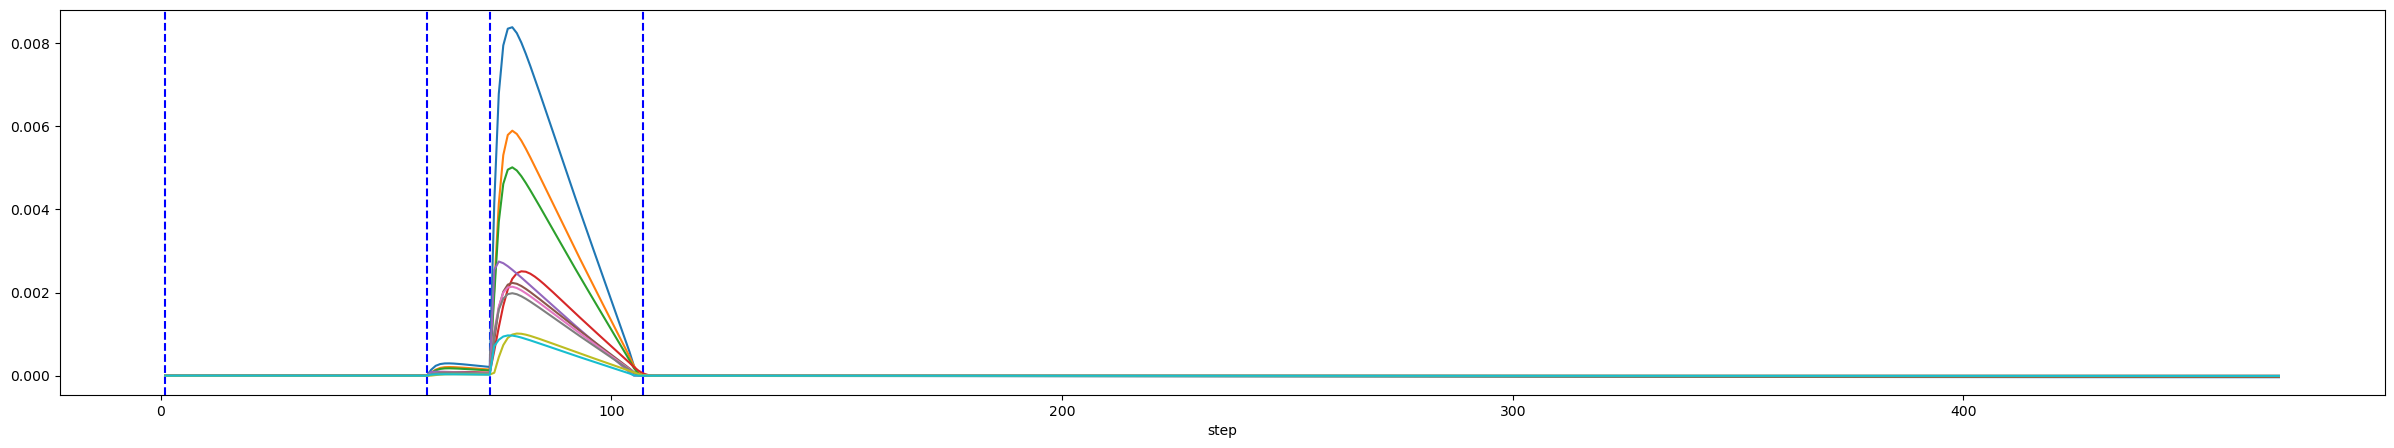

In [39]:
fig, ax = plt.subplots(figsize=(30,5))

for occ in [(supchain.events_date[i]-supchain.events_date[0] + 1) for i in range(len(supchain.secs_dir_imp))]:
    plt.axvline(x = occ, color = 'b', linestyle="--")

prod_losses_che.loc[:, ('CHE',
                        mainly_aff_che_secs.index.get_level_values(1))].plot(ax=ax,legend=False)
# add small legend
# add y-axis label

In [40]:
supchain.calc_impacts(io_approach='boario', boario_type = 'recovery', boario_aggregate = 'sep')

Processed: Step: 0 ~   0% ETA:  --:--:--
Processed: Step: 1 ~   0% ETA:   0:00:53
Processed: Step: 2 ~   0% ETA:   0:00:54
Processed: Step: 3 ~   0% ETA:   0:00:54
Processed: Step: 4 ~   0% ETA:   0:00:54
Processed: Step: 5 ~   1% ETA:   0:00:54
Processed: Step: 6 ~   1% ETA:   0:00:55
Processed: Step: 7 ~   1% ETA:   0:00:56
Processed: Step: 8 ~   1% ETA:   0:00:55
Processed: Step: 9 ~   1% ETA:   0:00:56
Processed: Step: 10 ~   2% ETA:   0:00:57
Processed: Step: 11 ~   2% ETA:   0:00:57
Processed: Step: 12 ~   2% ETA:   0:00:57
Processed: Step: 13 ~   2% ETA:   0:00:57
Processed: Step: 14 ~   2% ETA:   0:00:57
Processed: Step: 15 ~   3% ETA:   0:00:57
Processed: Step: 16 ~   3% ETA:   0:00:57
Processed: Step: 17 ~   3% ETA:   0:00:57
Processed: Step: 18 ~   3% ETA:   0:00:56
Processed: Step: 19 ~   4% ETA:   0:00:56
Processed: Step: 20 ~   4% ETA:   0:00:56
Processed: Step: 21 ~   4% ETA:   0:00:56
Processed: Step: 22 ~   4% ETA:   0:00:56
Processed: Step: 23 ~   4% ETA:   0:00:56
Pr

In the separated version, we get a list of dataframe, with each dataframe showing impact from a single event.

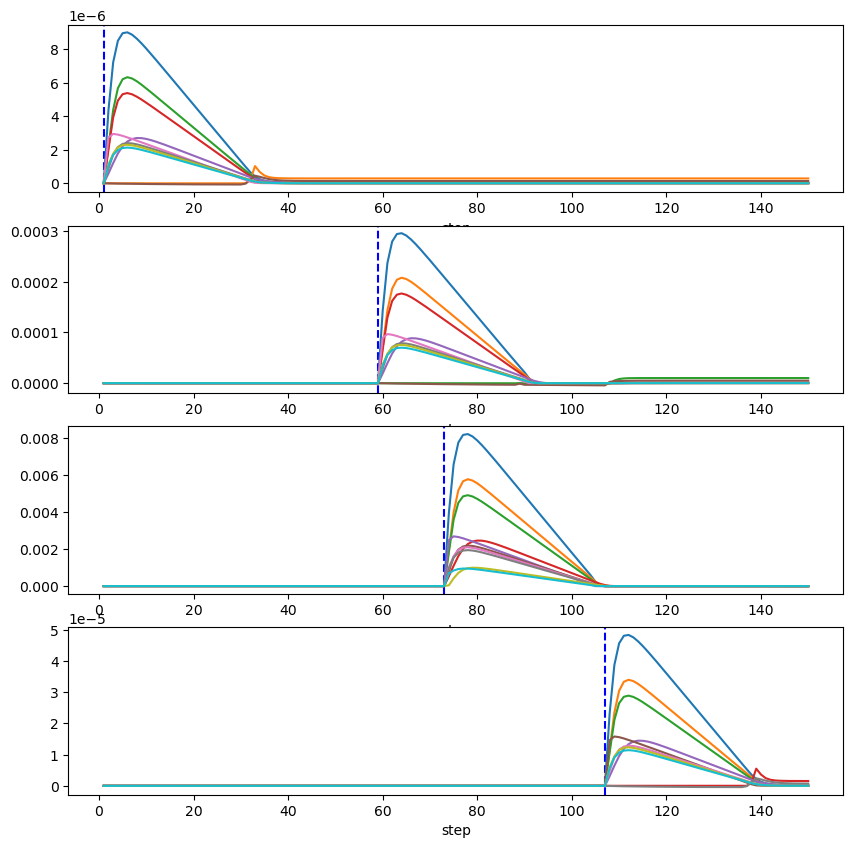

In [41]:
fig, ax = plt.subplots(len(supchain.events_date), 1, figsize=(10,10))

for i in range(len(supchain.events_date)):

    # make this a function where one passes country(-ies) or sectors of interest, 
    # or perhaps just pass indicators to investigate the worst (10, 15, 20 etc.) 
    # countries, sectors or both affected.

    prod_losses_che = (supchain.secs_indir_imp['boario_recovery_sep'][i].iloc[0]
                    - supchain.secs_indir_imp['boario_recovery_sep'][i].iloc[1:]
                    ).loc[:,('CHE', slice(None))]
    mainly_aff_che_secs = prod_losses_che.sum(0).sort_values(ascending=False)[:10] # we sum it because it is cumulated over time

    ax[i].axvline(x = supchain.events_date[i]-supchain.events_date[0] + 1, color = 'b', linestyle="--")

    prod_losses_che.loc[:150, ('CHE',
                            mainly_aff_che_secs.index.get_level_values(1))
                            ].plot(ax=ax[i],legend=False)
    
    #ax[i].set_ylim(0, 0.1)

In [42]:
supchain.calc_impacts(io_approach='boario', boario_type = 'rebuild', boario_aggregate = 'agg')

TypeError: _instantiate() missing 2 required keyword-only arguments: 'rebuild_tau' and 'rebuilding_sectors'

In [43]:
supchain.calc_impacts(io_approach='boario', boario_type = 'shock-prod', boario_aggregate = 'agg')

Processed: Step: 0 ~   0% ETA:  --:--:--
Processed: Step: 1 ~   0% ETA:   0:01:03
Processed: Step: 2 ~   0% ETA:   0:00:59
Processed: Step: 3 ~   0% ETA:   0:00:56
Processed: Step: 4 ~   0% ETA:   0:00:58
Processed: Step: 5 ~   1% ETA:   0:00:57
Processed: Step: 6 ~   1% ETA:   0:00:57
Processed: Step: 7 ~   1% ETA:   0:00:56
Processed: Step: 8 ~   1% ETA:   0:00:55
Processed: Step: 9 ~   1% ETA:   0:00:54
Processed: Step: 10 ~   2% ETA:   0:00:54
Processed: Step: 11 ~   2% ETA:   0:00:54
Processed: Step: 12 ~   2% ETA:   0:00:53
Processed: Step: 13 ~   2% ETA:   0:00:55
Processed: Step: 14 ~   2% ETA:   0:00:55
Processed: Step: 15 ~   3% ETA:   0:00:55
Processed: Step: 16 ~   3% ETA:   0:00:55
Processed: Step: 17 ~   3% ETA:   0:00:54
Processed: Step: 18 ~   3% ETA:   0:00:54
Processed: Step: 19 ~   4% ETA:   0:00:54
Processed: Step: 20 ~   4% ETA:   0:00:54
Processed: Step: 21 ~   4% ETA:   0:00:53
Processed: Step: 22 ~   4% ETA:   0:00:55
Processed: Step: 23 ~   4% ETA:   0:00:55
Pr

In [44]:
# make this a function where one passes country(-ies) or sectors of interest, or perhaps just pass indicators to investigate the worst (10, 15, 20 etc.) countries, sectors or both affected.
prod_losses_che = (supchain.secs_indir_imp['boario_shock-prod_agg'].iloc[0]
                - supchain.secs_indir_imp['boario_shock-prod_agg'].iloc[1:]
                ).loc[:,('CHE', slice(None))]
mainly_aff_che_secs = prod_losses_che.sum(0).sort_values(ascending=False)[:10] # we sum it because it is cumulated over time
mainly_aff_che_secs

region  sector                                                                       
CHE     Insurance, reinsurance and pension funding, except compulsory social security    0.035860
        Manufacture of computer, electronic and optical products                         0.018205
        Manufacture of basic pharmaceutical products and pharmaceutical preparations     0.010189
        Manufacture of chemicals and chemical products                                   0.008451
        Electricity, gas, steam and air conditioning supply                              0.005357
        Manufacture of fabricated metal products, except machinery and equipment         0.003972
        Manufacture of machinery and equipment n.e.c.                                    0.003883
        Manufacture of furniture; other manufacturing                                    0.003746
        Manufacture of electrical equipment                                              0.003648
        Manufacture of basic met

<Axes: xlabel='step'>

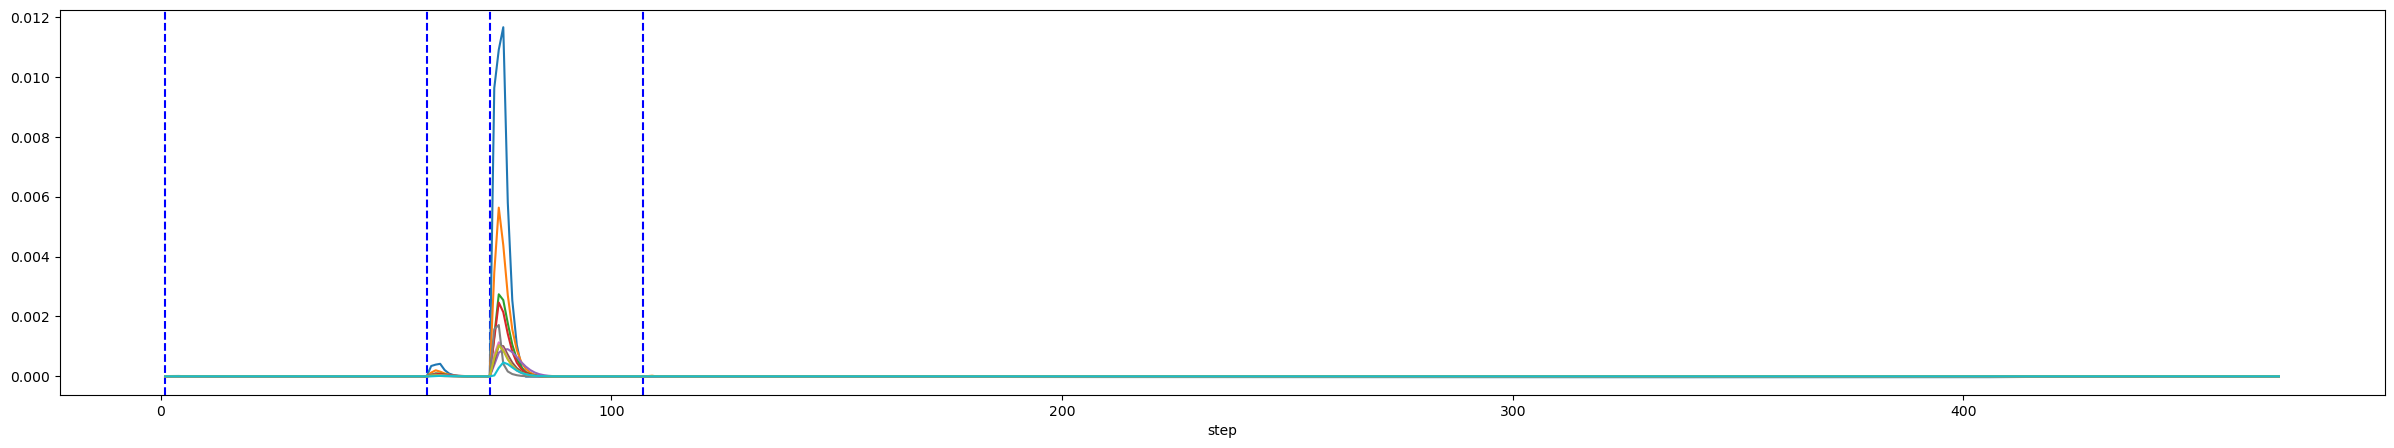

In [45]:
fig, ax = plt.subplots(figsize=(30,5))

for occ in [(supchain.events_date[i]-supchain.events_date[0] + 1) for i in range(len(supchain.secs_dir_imp))]:
    plt.axvline(x = occ, color = 'b', linestyle="--")

prod_losses_che.loc[:, ('CHE',
                        mainly_aff_che_secs.index.get_level_values(1))].plot(ax=ax,legend=False)
# add small legend
# add y-axis label

- Make simple functions to investigate boario
- choose something else than CHE - irrelevant impacts !! 
- try other boario versions